<a href="https://colab.research.google.com/github/ReutDanino/Semantic-segmentation-mini-project/blob/main/Final_new_network_DeeplabV3Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install

In [ ]:
!pip install keras

In [1]:
pip install keras==<version>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install keras==<version>'


In [2]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


## Imports

In [3]:
# Import necessary libraries
import numpy as np
from PIL import Image
import os
import glob
import cv2
import matplotlib.pyplot as plt
from glob import glob
from glob import glob as globlib
from scipy.io import loadmat
import keras
from keras import layers, Model, Input
from keras import ops
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

##Connection to the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Paths


In [5]:
NUM_TRAIN_IMAGES = 300
NUM_VAL_IMAGES = 30

# Define paths for images and masks for train
image_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/train/CXR_png/*.png"))[:NUM_TRAIN_IMAGES]
mask_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/train/masks/*.png"))[:NUM_TRAIN_IMAGES]

# Define paths for images and masks for validation
image_val_paths = sorted(globlib("//content/drive/MyDrive/תמונות מעובדות/validation/CXR_png/*.png"))[:NUM_VAL_IMAGES]
mask_val_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/validation/masks/*.png"))[:NUM_VAL_IMAGES]

# Define paths for images and masks for test
image_test_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/*.png"))
mask_test_paths = sorted(globlib("/content/drive/MyDrive/תמונות מעובדות/test מחולק/masks/*.png"))

##Data preparation

In [6]:
# Define variables
IMAGE_SIZE = 400
BATCH_SIZE = 4
NUM_CLASSES = 1


# Function to read and normalize images
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.0
        image = tf.where(image > 0, 1.0, 0.0)
    else:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.0
    return image


# Checks if the image contains any NaN (Not a Number) or Inf (Infinity) values.
def validate_image(image):
    return not tf.reduce_any(tf.math.is_nan(image)) and not tf.reduce_any(tf.math.is_inf(image))


# Function to load image and mask data
def load_data(image_path, mask_path):
    image = read_image(image_path)
    mask = read_image(mask_path, mask=True)
    return image, mask


# Function to generate data batches
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# Function to display images and masks from the dataset
def display_images_and_masks(dataset):
    for images, masks in dataset:
        plt.figure(figsize=(10, 5 * BATCH_SIZE))
        for i in range(BATCH_SIZE):
            plt.subplot(BATCH_SIZE, 2, 2 * i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title('Image')

            plt.subplot(BATCH_SIZE, 2, 2 * i + 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')
            plt.title('Mask')
        plt.show()


# Generate training dataset from image and mask paths
train_dataset = data_generator(image_paths, mask_paths)

# Generate validation dataset from validation image and mask paths
val_dataset = data_generator(image_val_paths, mask_val_paths)

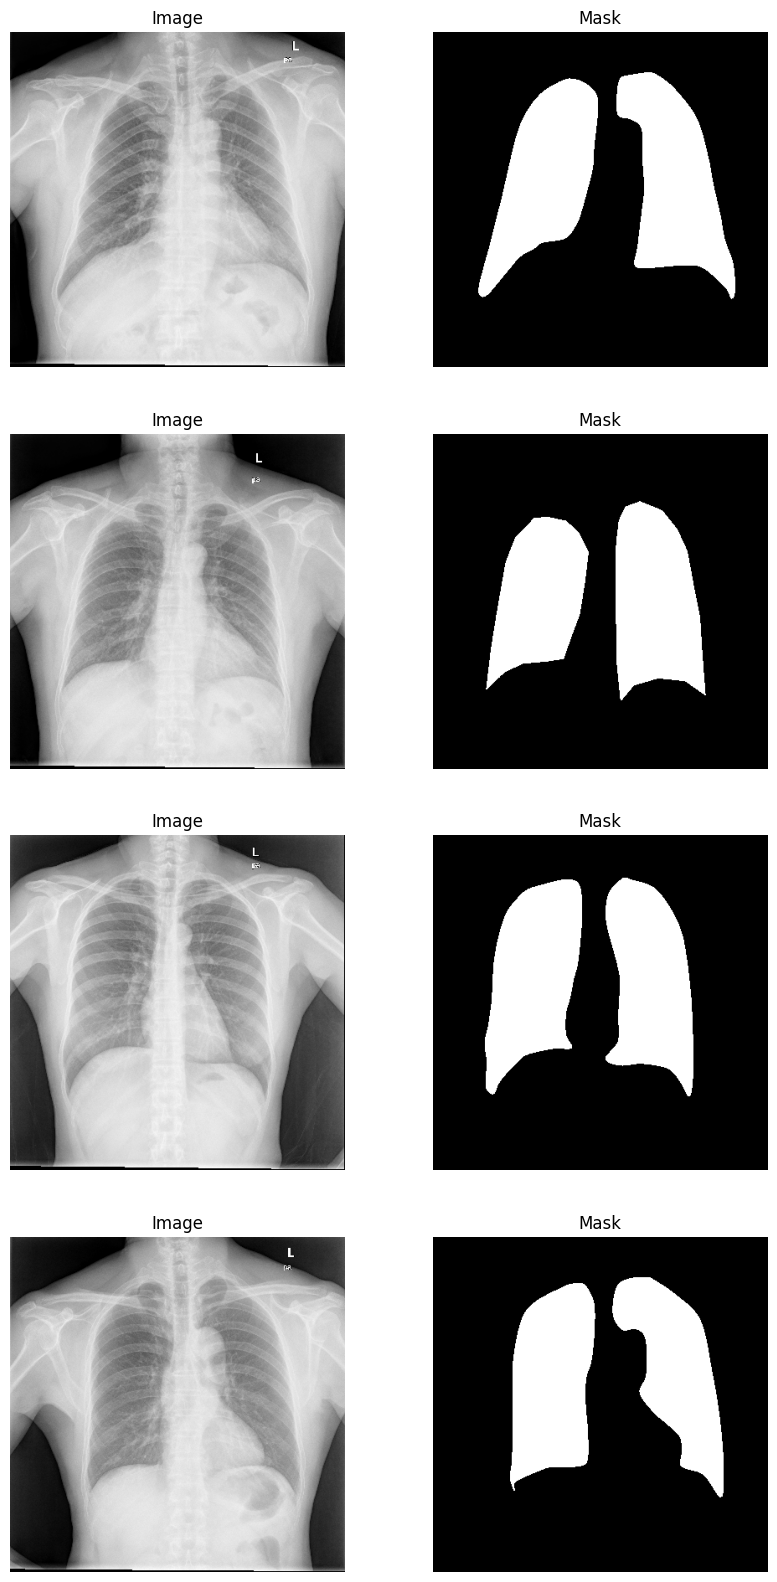

In [11]:
# Display images and their corresponding masks from the train
display_images_and_masks(train_dataset.take(1))

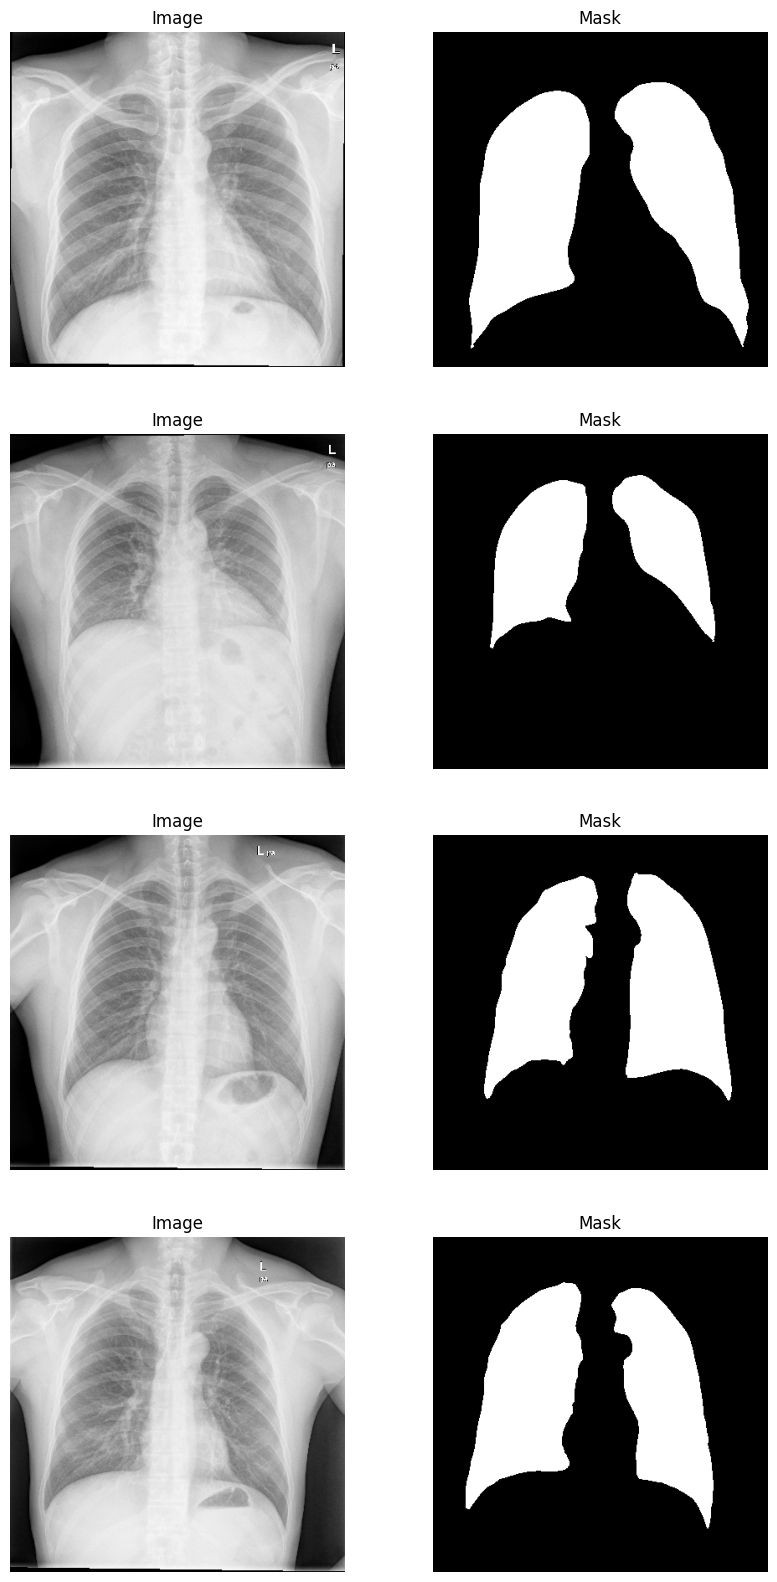

In [10]:
# Display images and their corresponding masks from the validation
display_images_and_masks(val_dataset.take(1))

In [ ]:
# Functions to calculate IoU
def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Functions to calculate IoU threshold
def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1e-6):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    return iou(y_true, y_pred, smooth)

In [ ]:
class DilatedSpatialPyramidPooling(layers.Layer):
  #Custom Keras layer implementing Dilated Spatial Pyramid Pooling (DSPP)
    def __init__(self, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        # 1x1 average pooling layer
        self.pool = layers.AveragePooling2D(pool_size=(1, 1))
        # 1x1 convolution layer applied after pooling
        self.pool_conv = layers.Conv2D(
            256, kernel_size=1, use_bias=True, kernel_initializer=HeNormal()
        )
        # Batch normalization layers
        self.bn_layers = [layers.BatchNormalization() for _ in range(5)]
        # Convolution blocks with different dilation rates
        self.conv_blocks = []

        # Create convolution blocks with different dilation rates
        for dilation_rate in [1, 6, 12, 18]:
            self.conv_blocks.append(
                layers.Conv2D(
                    256,
                    kernel_size=3 if dilation_rate > 1 else 1,   # Use kernel size of 3 for dilated convolutions, 1 otherwise
                    dilation_rate=dilation_rate,                 # Set the dilation rate
                    padding="same",                              # Keep the spatial dimensions of the output same as input
                    use_bias=False,
                    kernel_initializer=HeNormal()
                )
            )
        # Final 1x1 convolution layer
        self.final_conv = layers.Conv2D(
            256, kernel_size=1, use_bias=False, kernel_initializer=HeNormal()
        )
        # Final batch normalization layer
        self.final_bn = layers.BatchNormalization()


    #Defines the forward pass of the Dilated Spatial Pyramid Pooling layer.
    def call(self, inputs):
        # Get the input shape
        input_shape = tf.shape(inputs)
        height = input_shape[1]
        width = input_shape[2]

        # Pooling
        out_pool = self.pool(inputs)
        out_pool = self.pool_conv(out_pool)
        out_pool = self.bn_layers[0](out_pool)
        out_pool = relu(out_pool)
        out_pool = tf.image.resize(out_pool, (height, width), method=tf.image.ResizeMethod.BILINEAR)

        # Convolutions
        conv_outputs = []
        for i, conv_block in enumerate(self.conv_blocks):
            x = conv_block(inputs)
            x = self.bn_layers[i + 1](x)
            x = relu(x)
            conv_outputs.append(x)

        # Concatenate
        x = layers.Concatenate(axis=-1)([out_pool] + conv_outputs)
        x = self.final_conv(x)
        x = self.final_bn(x)
        return relu(x)

# Function to build the DeepLabV3+ model
def convolution_block(inputs, num_filters=256, kernel_size=3, dilation_rate=1):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Builds the DeeplabV3+ model using ResNet50 as the backbone
def DeeplabV3Plus(image_size, num_classes):
    model_input = layers.Input(shape=(image_size, image_size, 3))   # Define input layer
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    # Extract features from the ResNet50 backbone
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = convolution_block(x, 256, 3, 1)
    # Upsample the feature map
    x = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]), interpolation="bilinear")(x)
    # Extract lower-level features from ResNet50
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    # Concatenate the upsampled features and the lower-level features
    x = layers.Concatenate()([x, input_b])
    x = convolution_block(x, 256, 3, 1)
    x = convolution_block(x, 256, 3, 1)
    # Final upsampling to match the original input size
    x = layers.UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation="bilinear")(x)
    # Final convolution layer to get the desired number of output classes
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)
    return Model(inputs=model_input, outputs=model_output)


# Define image size and number of output classes
IMAGE_SIZE = 400
NUM_CLASSES = 1

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# Display the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 400, 400, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 406, 406, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 200, 200, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 200, 200, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 200, 200, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 202, 202, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 100, 100, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 100, 100, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 100, 100, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 100, 100, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 100, 100, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 100, 100, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 100, 100, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 10,208,577 (38.94 MB)

 Trainable params: 10,178,401 (38.83 MB)

 Non-trainable params: 30,176 (117.88 KB)

In [ ]:
# Compile the model with the Adam optimizer, binary crossentropy loss, and IOU metrics
model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[iou, iou_thresholded])
# Train the model on the training dataset and validate on the validation dataset
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

# Save the trained model to a file
model.save('/content/drive/MyDrive/myNew2_model.h5')

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 337ms/step - iou: 0.6822 - iou_thresholded: 0.7741 - loss: 0.1739 - val_iou: 0.1313 - val_iou_thresholded: 2.6892e-11 - val_loss: 0.5426
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - iou: 0.8534 - iou_thresholded: 0.9009 - loss: 0.0643 - val_iou: 0.0370 - val_iou_thresholded: 2.6892e-11 - val_loss: 0.8301
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - iou: 0.8755 - iou_thresholded: 0.9143 - loss: 0.0524 - val_iou: 0.0131 - val_iou_thresholded: 2.6892e-11 - val_loss: 1.0912
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - iou: 0.8887 - iou_thresholded: 0.9240 - loss: 0.0459 - val_iou: 0.0118 - val_iou_thresholded: 2.6888e-11 - val_loss: 1.1196
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - iou: 0.9056 - iou_thresholded: 0.9372 - loss: 0.0375 - val_iou: 0.0041 - val_iou_thresholded: 2.6892e-11 - val_loss: 1.3878
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - iou: 0.9148 - iou_thresholded: 0.9437 - loss: 0.03

In [ ]:
imgs_list = []
masks_list = []
imgs_val_list = []
masks_val_list = []

# Load and preprocess images and masks (to check the performance)
for image, mask in zip(image_paths, mask_paths):
    imgs_list.append(np.array(Image.open(image).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))))
    mask_img = Image.open(mask).resize((IMAGE_SIZE, IMAGE_SIZE))
    masks_list.append(np.array(mask_img))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

# Convert masks to binary (black and white)
masks_np = np.where(masks_np > 0, 255, 0)

# Normalize images and masks
x_train = np.asarray(imgs_np, dtype=np.float32)/255
y_train = np.asarray(masks_np, dtype=np.float32)/255

# Reshape masks for training
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)




# Load and preprocess images and masks (to check the performance)
for image_val, mask_val in zip(image_val_paths, mask_val_paths):
    imgs_val_list.append(np.array(Image.open(image_val).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))))
    mask_val_img = Image.open(mask_val).resize((IMAGE_SIZE, IMAGE_SIZE))
    masks_val_list.append(np.array(mask_val_img))

imgs_val_np = np.asarray(imgs_val_list)
masks_val_np = np.asarray(masks_val_list)

# Convert masks to binary (black and white)
masks_val_np = np.where(masks_val_np > 0, 255, 0)

# Normalize images and masks
x_val = np.asarray(imgs_val_np, dtype=np.float32)/255
y_val = np.asarray(masks_val_np, dtype=np.float32)/255

# Reshape masks for training
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)

In [ ]:
# Evaluate the model on training data
train_loss, train_iou, train_iou_thresholded = model.evaluate(x_train, y_train, verbose=0)

# Print training loss and IoU metrics
print(f'Train Loss: {train_loss:.2f}')
print(f'Train IoU: {train_iou:.2f}')
print(f'Train IoU Thresholded: {train_iou_thresholded:.2f}')

# Evaluate the model on validation data
val_loss, val_iou, val_iou_thresholded = model.evaluate(x_val, y_val, verbose=0)

# Print validation loss and IoU metrics
print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation IoU: {val_iou:.2f}')
print(f'Validation IoU Thresholded: {val_iou_thresholded:.2f}')

Train Loss: 0.04
Train IoU: 0.92
Train IoU Thresholded: 0.94
Validation Loss: 0.14
Validation IoU: 0.87
Validation IoU Thresholded: 0.88


In [ ]:
# Sort the test image and mask
# Ensuring that images and their corresponding masks are aligned
image_test_paths.sort()
mask_test_paths.sort()

# Initialize lists to store the test images and masks
num_images_test = len(image_test_paths)
image_test_list = []
mask_test_list = []

# Load and preprocess the test images and masks
for image_test, mask_test in zip(image_test_paths, mask_test_paths):
    # Load and preprocess the test image
    image_test_list.append(np.array(Image.open(image_test).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))))
    # Load and preprocess the test mask
    im_test = Image.open(mask_test).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask_test_list.append(np.array(im_test))


# Convert the lists to numpy arrays
imgs_np_test = np.asarray(image_test_list)
masks_np_test = np.asarray(mask_test_list)

# Binarize the test masks (convert to 0 and 255)
masks_np_test = np.where(masks_np_test > 0, 255, 0)


# Normalize the test images and masks
x_test = np.asarray(imgs_np_test, dtype=np.float32)/255
y_test = np.asarray(masks_np_test, dtype=np.float32)/255


# Reshape the test masks to add the channel dimension
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

# Load the model
#model_path = '/content/drive/MyDrive/myNew2_model.h5'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})


# Evaluate the model on the test data
test_loss, test_iou, test_iou_thresholded = model.evaluate(x_test, y_test, verbose=0)

# Print the test evaluation results
print(f'Test Loss: {test_loss:.2f}')
print(f'Test IoU: {test_iou:.2f}')
print(f'Test IoU Thresholded: {test_iou_thresholded:.2f}')

Test Loss: 0.08
Test IoU: 0.90
Test IoU Thresholded: 0.91


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Input image shape: (400, 400, 3)
Input image values (min, max): (0.0, 1.0)
Predicted mask shape: (400, 400, 1)
Predicted mask values (min, max): (1.0153803e-05, 1.0)
Binary mask values (unique): [0 1]


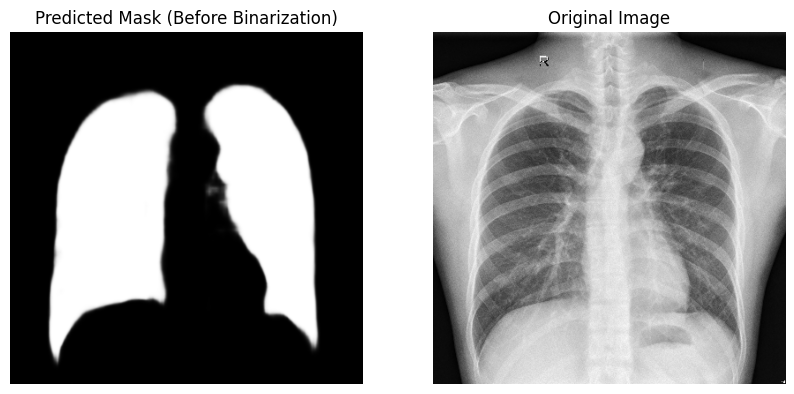

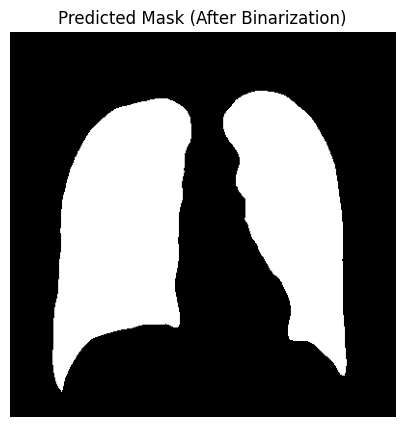

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img_np = np.array(img, dtype=np.float32) / 255.0
    return img_np

# Function to predict and visualize the results
def predict_and_visualize(image_path, target_size, model):
    # Load and preprocess the image
    input_image = load_and_preprocess_image(image_path, target_size)

    # Expand dimensions to match the model input
    input_image_expanded = np.expand_dims(input_image, axis=0)

    # Predict the mask
    predicted_mask = model.predict(input_image_expanded)[0]

    # Print the image and mask values
    print(f"Input image shape: {input_image.shape}")
    print(f"Input image values (min, max): {input_image.min(), input_image.max()}")
    print(f"Predicted mask shape: {predicted_mask.shape}")
    print(f"Predicted mask values (min, max): {predicted_mask.min(), predicted_mask.max()}")

    # Display the predicted mask before binarization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask (Before Binarization)')
    plt.axis('off')

    # Binarize the predicted mask
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    # Print the binary mask values
    print(f"Binary mask values (unique): {np.unique(predicted_mask_binary)}")

    # Display the original image
    plt.subplot(1, 2, 2)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    # Display the predicted mask after binarization
    plt.figure(figsize=(10, 5))
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask (After Binarization)')
    plt.axis('off')

    plt.show()

# load model
#model_path = '/content/drive/MyDrive/myNew2_model.h5'
#model = load_model(model_path, custom_objects={'iou': iou, 'iou_thresholded': iou_thresholded})

# Example usage of the function
image_path = "/content/drive/MyDrive/תמונות מעובדות/test מחולק/CXR_png/CHNCXR_0557_1.png"  # Path to the image
target_size = (400, 400)  # Desired image size for the model
predict_and_visualize(image_path, target_size, model)